# Aula 6

# "Data Pipelines" - Parte 2

# Etapa de treinamento

### Eduardo Lobo Lustosa Cabral

## 1. Objetivos

Apresentar ferramentas do TensorFlow para criar "data pipelines" eficientes.

Apresentar formas de treinar RNAs usando ferramentas de "data pipelines" do TensorFlow. 

Exemplos de treinamento de RNAs usando "data pipelines".

### Importa principais bibliotecas

In [1]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## 2. Data Pipelines

Com já vimos, existem muitos tipos de dados e problemas. Como por exemplo:

-	Imagens $\to$ classificação, detecção e localização de objetos, segmentação, geração de novas imagens.
-	Texto $\to$  classificação, análise de sentimento, geração de novos textos, tradução de texto, chatbot.
- Áudio $\to$  reconhecimento de voz, música, geração de áudio (música e voz).
- Vídeo $\to$  classificação, reconhecimento de ação, rastreamento de objetos, entendimento de vídeo.
- Séries temporais $\to$  previsão, regressão (ajuste de função).
- Dados estruturados $\to$ regressão, sistemas de recomendação, classificação. 

<br>
Para processar e carregar dados para treinar uma RNA de forma eficiente deve-se criar um "data pipeline". 

**Data pipelines** funcionam no princípio ETC (Extrair, Transformar e Carregar) que em inglês é ETL (Extraction, Tranformation and Load).

- **Extrair** $\to$ carrega dados originais do local onde se encontram e traz para o nosso ambiente de computação;
- **Transformar** $\to$ processa os dados para serem colocados em formatos adequados que possam ser usados por uma RNA;
- **Carregar** $\to$ alimenta a RNA com dados durante o seu treinamento ou para realizar previsões quando colocada em operação.

<br>
Cada tipo de dado exige um "data pipeline" diferente. Por exemplo:

- Imagens $\to$ ler arquivos, aplicar transformações em cada imagem e juntar aletoriamente em lotes para treinamento.
-	Texto $\to$ ler arquivos, pode envolver extrair palavras ou letras do texto, converter em vetores “one-hote” ou “embeding” e criar lotes de sequências que podem ter comprimentos diferentes.
-	Vídeo $\to$ ler arquivos, separar imagens dos vídeos, aplicar transformações em cada imagem e juntar em lotes de treinamento que podem ter comprimentos diferentes.
- Áudio e séries temporais $\to$ ler arquivos, criar janelas com dados temporais, aplicar transformações nos dados, juntar em lotes de treinamento.
- Dados estruturados $\to$ ler arquivos, transformar dados e juntar em lotes para treinamento. 

#### "Data pipelines" com TensorFlow

O TensorFlow fornece ferramentas para realizar as três etapas de um "data pipeline" de forma eficiente para qualquer tipo de dado e problema.

A grande vantagem de usar as ferramentas do TensorFlow é que elas são otimizadas para funcionar com os métodos de treinamento do Keras e, assim, o processo de treinamento é mais rápido.

O módulo **`tf.data`** do TensorFlow disponibiliza ferramentas para criar "data pipelines" complexos de forma simples (https://www.tensorflow.org/api_docs/python/tf/data).

Na Aula 4 vimos as etapas de "extração" e "transformação" dos dados **$\to$ nessa aula veremos a etapa de carregar os dados no treinamento de uma RNA.**

## 3. Treinamento

A última etapa de um "data pipeline" de dados para desenvolver uma RNA é carregar os dados durante o processo de treinamento.

Com os dados em um objeto Dataset, eles são fornecidos para o treinamento da RNA de forma otimizada utilizando da melhor forma possível todos os recursos de CPU/GPU e memória disponíveis.

Com um Dataset é possível utilizar os métodos `fit()`, `evaluate()` e `predict()` do Keras.

Como exemplos de usar um conjunto de dados no formato Dataset no treinamento de uma RNA, vamos mostrar dois casos:

1. Dados na forma de imagens em tensores para classificação multiclasse;
2. Dados estruturados em arquivo CSV para classificaçao binária com classes desbalanceadas. 

## 4. Classificação  multiclasse com dados em imagens

Nesse exemplos vamos utilizar os dados do conjunto Fashion-MNIST. 

Como já vimos o conjunto de dados Fashion-MNIST consiste de imagens de artigos de vesturário divididas em 10 classes.

### 4.1 Carregar dados

O código abaixo carrega os dados da Fashion-MNIST da coleção do Keras e separa as imagens de entrada e as classes.

In [3]:
# Carrega conjunto de dados do keras
train, test = tf.keras.datasets.fashion_mnist.load_data()

# Separa imagens e classes
images_train, labels_train = train
images_test, labels_test = test

# Mostra dimensões dos dados
print('Dimensão do tensor de imagens de treinamento:', images_train.shape)
print('Dimensão do tensor de imagens de teste:', images_test.shape)

Dimensão do tensor de imagens de treinamento: (60000, 28, 28)
Dimensão do tensor de imagens de teste: (10000, 28, 28)


Pode-se ver que esse conjunto de dados possui 60.000 exemplos de treinamento e 10.000 exemplos de teste. Além disso, as imagens tem 28x28 pixels e são em tons de cinza.

### 4.2 Criar Datasets de treinamento e teste

Na célula abaixo são criados os Datasets de treinamento e teste. 

In [4]:
# Cria datasets de treinameto e teste
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
fmnist_test_ds = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

Para transformar os dados de forma a que possam ser usados por uma RNA, vamos definir a função `transform()`, que realiza as seguintes operações ao carregar os lotes de dados:

1. Redefine o tipo dos dados das imagens para serem reais;
2. Normaliza as imagens para os pixels terem valores entre 0 e 1;
3. Codifica as classes das imagens para vetores one-hot.

In [5]:
## Define função para normalizar as imagens codificar saída
def transform(x, y):
    x_norm = tf.cast(x, dtype=tf.float32)/255.
    y_int = tf.cast(y, dtype=tf.int32)
    y_hot = tf.one_hot(y_int, 10)
    return x_norm, y_hot

- Observe que essa função recebe tanto as entradas como as saídas dos exemplos de treinamento em razão dos Datasets retornarem pares imagem-classe.

Agora vamos introduzir a transformação dos dados nos Datasets de treinamento e teste criados anteriormente. Para isso usamos o método `map` e a função `transform()`.

In [6]:
# Define tamanho do lote
batch_size = 32

# Cria Dataset com a transformação que normaliza as imagens e codifica saída
fmnist_train_ds = fmnist_train_ds.map(transform)
fmnist_test_ds = fmnist_test_ds.map(transform)

# Define tamanho de lotes e embaralha dados
fmnist_train_ds = fmnist_train_ds.shuffle(1000).batch(batch_size)
fmnist_test_ds = fmnist_test_ds.shuffle(1000).batch(batch_size)

- Observe que esses Datasets retornam um lote de imagens normalizadas e saídas em vetores one-hot. Para realizar essas transfromações é usado o método `map` que chama a função `transform()`.

Para verificar se os Datasets estão funcionando corretamente, vamos criar um lote e apresentar alguns exemplos

Classe: tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


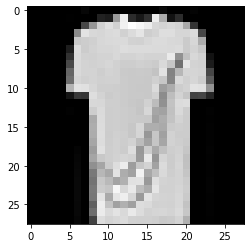

Dimensão do lote: (32, 28, 28)
Valores de alguns pixels: [0.8039 0.8078 0.8    0.7922 0.7882]


In [10]:
# Gera um lote de treinamento
img, y = next(iter(fmnist_train_ds))

# Mostra primeiro exemplo do lote
print('Classe:', y[0])
plt.imshow(img[0], cmap='gray')
plt.show()

# Apresenta dimensão do lote de imagens e alguns pixels da primeira imagem
print('Dimensão do lote:', img.shape)
print('Valores de alguns pixels:', img[0,14,10:15].numpy())

### 4.3 Configuração e compilação da RNA

Como as imagens tem dimensão pequena (28x28) e são em tons de cinza, vamos usar uma RNA simples com duas camadas densas para resolver esse problema.

A RNA é compilada com os seguintes parâmetros:

- Método de otimização: Adam com a sua taxa de aprendizado padrão (`lr=0.001`);
- Função de custo: `CategoricalCrossentropy`;
- Métrica: `accuracy`.

In [11]:
# Define dimensão das imagens
img_size = (28, 28)

# Cria RNA 
rna = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=img_size),
      tf.keras.layers.Dense(32, activation='relu'),                    
      tf.keras.layers.Dense(10, activation='softmax')])

# Apresenta sumário da RNA
rna.summary()

# Compila RNA
rna.compile(optimizer='adam',
            loss= tf.keras.losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


- A primeira camada da RNA é uma camada tipo `Flatten` para redimensionar as imagens e transformá-las em um vetor para poderem ser processadas por uma camada densa. Observe que o redimensionamento das imagens foi incluído dentro da RNA.

### 4.4 Treinamento da RNA
 
Para treinar a RNA basta passar os Datasets de treinamento e teste da mesma forma como se estivessem em tensores.
 
Somente para exemplificar, vamos usar poucas épocas de treinamento.

In [12]:
rna.fit(fmnist_train_ds, epochs=10, validation_data=fmnist_test_ds)

Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 0.7219 - accuracy: 0.7536 - val_loss: 0.4784 - val_accuracy: 0.8302
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4201 - accuracy: 0.8530 - val_loss: 0.4513 - val_accuracy: 0.8456
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3823 - accuracy: 0.8656 - val_loss: 0.4023 - val_accuracy: 0.8593
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3606 - accuracy: 0.8713 - val_loss: 0.3968 - val_accuracy: 0.8584
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3452 - accuracy: 0.8761 - val_loss: 0.3984 - val_accuracy: 0.8614
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3342 - accuracy: 0.8789 - val_loss: 0.3717 - val_accuracy: 0.8654
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3224 - accuracy: 0.8834 - val_loss: 0.3836 - val_accuracy

**Importante:**

Como visto, um Dataset criado usando o método `repeat` gera infinitos exemplos de treinamento. Nesses casos, no treinamento deve-se usar o argumento `steps_per_epoch` para definir quantos lotes por época são desejados.

### 4.5 Avaliação da RNA

O método `evaluate` pode ser usado com os dados em um Dataset. 

Nesse caso pode-se se quiser, ou se for necessário, definir o número de lotes usados no treinamento com o argumento `steps`.

In [15]:
# Calcula função de custo e exatidão para todos os dados de teste 
loss, accuracy = rna.evaluate(fmnist_test_ds)

print("Função de custo:", loss)
print("Exatidão:", accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3833 - accuracy: 0.8655
Função de custo: 0.38332098722457886
Exatidão: 0.8654999732971191


In [16]:
# Calcula função de custo e exatidão para 10 lotes dos dados de teste 
loss, accuracy = rna.evaluate(fmnist_train_ds.repeat(), steps=10)

print("Função de custo:", loss)
print("Exatidão:", accuracy)

10/10 [==============================] - 0s 5ms/step - loss: 0.2676 - accuracy: 0.8906
Função de custo: 0.26759713888168335
Exatidão: 0.890625


### 4.6 Realização de previsões

Para usar o método `predict` para fazer previsões com a RNA as saídas não são necessárias. Assim, pode-se fazer o seguinte:

1. Criar um novo Dataset com somente as imagens de teste;
2. Usar o Dataset criado anteriormente como os dados de teste, que gera tanto as imagens como as classes, nesse caso as sáidas são ignoradas pelo método `predict`.

In [18]:
# Define função para somente normalizar imagens
def img_norm(x):
    x = tf.cast(x, dtype=tf.float32)/255.
    return x

# Cria novo Dataset somente com as imagens de teste sem as classes
predict_ds = tf.data.Dataset.from_tensor_slices(images_test)
predict_ds = predict_ds.map(img_norm).batch(batch_size)

# Realiza previsões 
result = rna.predict(predict_ds, steps=10)
                       
# Mostra dimensão dos resultados
print('Dimensão do tensor de previsões:', result.shape)
print('Probabilidades das classes do primeiro exemplo:', result[0])

Dimensão do tensor de previsões: (320, 10)
Probabilidades das classes do primeiro exemplo: [8.2854e-07 2.1298e-09 6.0267e-06 1.9959e-06 6.3607e-07 6.4042e-03
 1.8002e-07 1.5173e-01 2.3801e-04 8.4162e-01]


- Observe que as saídas da RNA são vetores, cujos elementos representam as probabilidades da imagem ser uma das classes.

Se quisermos verificar os resultados comparando com as classes reais, é mais fácil criar um lote de imagens e classes e depois usar a RNA com o método `predict` passando somente as imagens do lote.

In [19]:
# Gera lote de imagens e saídas reais 
img, y_real = next(iter(fmnist_test_ds))
                        
# Determina categoria da classe real
classe_real = np.argmax(y_real, axis=1)

# Calcula previsão da RNA para um lote de imagens
y_prev = rna.predict(img)
classe_prev = np.argmax(y_prev, axis=1)

Classe real: 6
Classe prevista: 6
Probabilidades das classe: [6.2678e-02 1.1513e-07 1.4786e-01 1.2641e-03 4.0749e-02 7.9797e-09
 7.3924e-01 1.0645e-10 8.2010e-03 2.0731e-09]


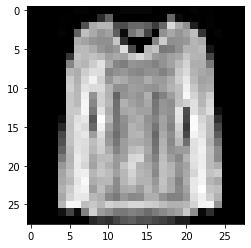

In [23]:
# Seleciona exemplo para mostrar resultado
index = 31

# Mostra um exemplo do lote
print('Classe real:', classe_real[index])
print('Classe prevista:', classe_prev[index])
print('Probabilidades das classe:' , y_prev[index])
plt.imshow(img[index], cmap='gray')
plt.show()

## 5.  Classificação binária com classes desbalanceadas - dados estruturados

Nesse exemplo vamos utilizar os dados do conjunto "The credit card fraud".

Como já vimos na aula passada, esse conjunto de dados consiste de um problema de classificação binária com dados desbalanceados, onde os dados sem fraude (classe = 0) representam 99,6% do total e os dados com fraude (classe=1) representam 0,4%.

### 5.1 Carregar os dados

Vamos carregar os dados para podermos visualizá-los diretamente do arquivo onde se encontram.

Nas céulas abaixo é definido o local onde se encontra os dados e depois os dados são carregados e descompactados.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


#### Características dos dados:

- Existem 284.807 exemplos de treinamento (cada linha é um exemplo);
- Cada exemplo é composto por um vetor de entrada com 30 características e uma saída;
- As 30 características são as primeiras 30 colunas dos dados;
- As saídas estão na última coluna, de nome "Class".

Vamos verificar os tipos de dados de cada coluna. Isso é importante porque se existir algum dado na forma de string ele tem que ser transformado para real.

In [25]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Vamos calcular a estatísticas das colunas para verificar como devemos pré-processar cada elemento dos exemplos de treinamento.

In [27]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 5.2 Pré-processamento dos dados

Para pré-processador os dados temos que fazer uma análise cuidadosa de cada característica (coluna) individualmente. Contudo, vamos realizar uma análise bastante simplificada, pois analisar dados não é o objetivo dessa aula.

Analisando cada uma das colunas de características temos que:

1. A primeira coluna, de nome "Time", não parece ter nenhuma informação relevante, assim, podemos tirá-la dos dados;


2. As colunas de nomes "V1" a "V28" são valores reais que variam de negativo a positivo e todas possuem média praticamente igual a 0 e desvio padrão igual a 1. Então vamos deixá-las como estão mesmo que alguns valores sejam da ordem de $10^1$.


3. A coluna "Amount" possui somente valores positivos, então podemos simplesmente dividi-la pelo seu valor máximo ou pelo seu desvio padrão.

Podemos realizar o pré-processamento dos dados previamente, ou podemos realizar esse processsamento ao obter os lotes de dados durante o treinamento $\to$ nesse exemplo vamos realizar o pré-processamento com o Pandas.

#### Embaralhamento aleatório dos dados

Para evitar qualquer tendência existente nos dados vamos embaralhá-los aleatóriamente.

In [28]:
df_shuffled=df.sample(frac=1)
df_shuffled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
85129,60619.0,-4.263879,1.531533,-0.881850,0.369056,-0.514140,-1.594743,-0.101346,1.193836,-0.849638,...,0.108703,-0.079921,-1.095747,0.480455,0.808549,-0.496222,-1.095475,-0.877064,2.69,0
252207,155697.0,1.969242,0.678002,-1.014505,3.566441,0.837346,0.035869,0.326780,-0.163696,-1.227127,...,0.218127,0.626940,0.062197,0.581720,0.192720,0.106373,-0.047759,-0.045136,7.53,0
115023,73720.0,-1.369214,1.433765,1.251207,-0.486622,0.260683,0.321789,0.582015,0.210786,0.333815,...,-0.301539,-0.359479,0.041979,-0.337050,-0.208764,0.104767,0.541115,0.149693,8.98,0
51618,45040.0,-0.844695,1.118401,1.017805,-0.155149,0.267244,-0.550155,0.537968,0.072987,-0.334224,...,-0.272191,-0.658426,0.062159,-0.056504,-0.081114,0.074103,0.244079,0.128198,4.49,0
261545,160067.0,1.993847,-0.055200,-0.419167,1.162541,-0.156547,-0.006745,-0.477176,-0.008400,0.769874,...,0.212646,0.789730,0.142122,0.584253,-0.009863,-0.587657,0.058732,-0.023721,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,939.0,-0.334479,0.226390,1.970052,1.813235,-0.308007,-0.046253,0.126702,-0.203989,0.316727,...,0.146153,0.900969,-0.210252,0.460403,-0.305401,-0.091483,-0.050375,-0.150339,64.50,0
32063,36623.0,1.323817,-0.859510,1.198582,-0.346080,-1.783544,-0.399575,-1.168795,0.093311,0.122400,...,-0.491773,-0.805212,0.156814,0.398901,-0.028284,0.963086,-0.012312,0.019683,7.55,0
39650,39913.0,-1.356966,-4.949006,-0.577724,-0.226900,-2.865498,-0.277220,0.872936,-0.162877,1.795679,...,0.963005,-0.109074,-1.241825,0.639999,-0.123270,-0.051770,-0.221688,0.242943,1334.00,0
142035,84556.0,-1.193074,1.788381,1.263928,2.175369,-0.444923,-0.075733,0.003887,0.802215,-1.274251,...,0.117001,0.243881,-0.146728,0.424643,0.242298,0.023849,-0.313478,-0.065787,11.35,0


#### Separar as saídas desejadas

Se vamos criar um Dataset a partir de um DataFrame Pandas devemos separar as entradas das saídas.

In [29]:
# Separa o vetor de saídas desejadas
y = df_shuffled.Class
y

85129     0
252207    0
115023    0
51618     0
261545    0
         ..
1214      0
32063     0
39650     0
142035    0
28740     0
Name: Class, Length: 284807, dtype: int64

#### Remover as colunas desnecessárias

Tendo o vetor de saídas desejadas, agora devemos remover as colunas "Time", que não tem informação nenhuma, e a coluna das saídas ("Class").

In [30]:
# remoção da coluna "Time" e da saída 
df_shuffled.drop(['Time', 'Class'], axis=1, inplace=True)
df_shuffled

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
85129,-4.263879,1.531533,-0.881850,0.369056,-0.514140,-1.594743,-0.101346,1.193836,-0.849638,-0.380547,...,-0.446457,0.108703,-0.079921,-1.095747,0.480455,0.808549,-0.496222,-1.095475,-0.877064,2.69
252207,1.969242,0.678002,-1.014505,3.566441,0.837346,0.035869,0.326780,-0.163696,-1.227127,1.522018,...,-0.207333,0.218127,0.626940,0.062197,0.581720,0.192720,0.106373,-0.047759,-0.045136,7.53
115023,-1.369214,1.433765,1.251207,-0.486622,0.260683,0.321789,0.582015,0.210786,0.333815,1.228397,...,0.585544,-0.301539,-0.359479,0.041979,-0.337050,-0.208764,0.104767,0.541115,0.149693,8.98
51618,-0.844695,1.118401,1.017805,-0.155149,0.267244,-0.550155,0.537968,0.072987,-0.334224,0.093294,...,0.176013,-0.272191,-0.658426,0.062159,-0.056504,-0.081114,0.074103,0.244079,0.128198,4.49
261545,1.993847,-0.055200,-0.419167,1.162541,-0.156547,-0.006745,-0.477176,-0.008400,0.769874,0.193681,...,-0.165150,0.212646,0.789730,0.142122,0.584253,-0.009863,-0.587657,0.058732,-0.023721,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-0.334479,0.226390,1.970052,1.813235,-0.308007,-0.046253,0.126702,-0.203989,0.316727,0.242608,...,0.133574,0.146153,0.900969,-0.210252,0.460403,-0.305401,-0.091483,-0.050375,-0.150339,64.50
32063,1.323817,-0.859510,1.198582,-0.346080,-1.783544,-0.399575,-1.168795,0.093311,0.122400,0.513097,...,-0.541264,-0.491773,-0.805212,0.156814,0.398901,-0.028284,0.963086,-0.012312,0.019683,7.55
39650,-1.356966,-4.949006,-0.577724,-0.226900,-2.865498,-0.277220,0.872936,-0.162877,1.795679,-1.554730,...,2.511559,0.963005,-0.109074,-1.241825,0.639999,-0.123270,-0.051770,-0.221688,0.242943,1334.00
142035,-1.193074,1.788381,1.263928,2.175369,-0.444923,-0.075733,0.003887,0.802215,-1.274251,-0.314212,...,-0.262530,0.117001,0.243881,-0.146728,0.424643,0.242298,0.023849,-0.313478,-0.065787,11.35


#### Normalizar a coluna "Amount"

In [33]:
x = df_shuffled.copy()
x["Amount"] = x["Amount"]/x.Amount.max()

x.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.171056e-15,3.044930e-16,-1.412964e-15,2.100790e-15,9.964609e-16,1.495077e-15,-6.116418e-16,1.279507e-16,-2.435559e-15,2.229535e-15,...,6.458078e-16,1.524623e-16,-3.402380e-16,2.593103e-16,4.468456e-15,5.280639e-16,1.669484e-15,-3.610374e-16,-1.212174e-16,0.003439
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.009736
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000218
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000856
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.003004
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


### 5.3 Criar objeto Dataset

Tendo os dados de entrada e de saída em um DataFrame Pandas, usamos o método `from_tensor_slices` para criar o Dataset. 

Para poder usar os dados do Dataframe, devemos tirar os nomes das colunas e passar somente os valores numéricos dos dados. Isso é feito usando a propriedade `values`, da forma apresentada na célula a seguir.

In [38]:
# Define tamanho do lote
batch_size = 1024

# Cria Dataset
creditcard_ds = tf.data.Dataset.from_tensor_slices((x.values, y.values)).batch(batch_size)

- Observe que os valores numéricos do Dataframe são passados para o Dataset usando `x.values` e `y.values`.

Vamos gerar um elemento do Dataset para verificar o resultado.

In [39]:
for element in creditcard_ds.take(1):
    print(format(element))

(<tf.Tensor: shape=(1024, 29), dtype=float64, numpy=
array([[-4.2639e+00,  1.5315e+00, -8.8185e-01, ..., -1.0955e+00,
        -8.7706e-01,  1.0471e-04],
       [ 1.9692e+00,  6.7800e-01, -1.0145e+00, ..., -4.7759e-02,
        -4.5136e-02,  2.9310e-04],
       [-1.3692e+00,  1.4338e+00,  1.2512e+00, ...,  5.4112e-01,
         1.4969e-01,  3.4954e-04],
       ...,
       [-4.2397e+00,  2.7200e+00,  8.0646e-02, ..., -3.9757e+00,
        -1.7962e+00,  5.4182e-04],
       [-6.9893e-01,  1.0205e+00, -1.7921e-01, ..., -2.2792e-01,
         1.9903e-01,  1.9423e-04],
       [-5.6410e+00,  5.1650e+00, -1.4642e+00, ...,  2.1088e+00,
         1.1237e+00,  3.4876e-04]])>, <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int64)>)


#### Divisão dos dados nos conjuntos de treinamento e teste

Vamos dividir os dados nos conjuntos de treinamento e teste, de forma a ter 80% dos dados no conjunto de treinamento e 20% no conjunto de teste.

In [40]:
# Define função que seleciona exemplos de teste
def is_test(x, y):
    return x % 5 == 0

# Define função que seleciiona exemplos de treinamento
def is_train(x, y):
    return not is_test(x, y)

# Define função que elimina índice usado para selecionar exemplos incluidos com o método enumerate
recover = lambda x,y: y

# Cria Dataset de teste
test_ds = creditcard_ds.enumerate().filter(is_test).map(recover)

# Cria Dataset de treinamento
train_ds = creditcard_ds.enumerate().filter(is_train).map(recover)

Vamos gerar um exemplo de treinamento e um de teste para verificar se os Datasets estão corretos.

In [41]:
# Verifica Dataset de treinamento 
for element in train_ds.take(1):
    print('Exemplo de treinamento:\m', format(element))

print(' ')

# Verifica Dataset de teste 
for element in test_ds.take(1):
    print('Exemplo de teste:\n', format(element))

Exemplo de treinamento:\m (<tf.Tensor: shape=(1024, 29), dtype=float64, numpy=
array([[-2.4543e-01,  1.3559e+00, -8.1479e-01, ..., -7.6784e-01,
        -2.5735e-01,  1.1677e-04],
       [ 4.4691e-01, -7.3020e-01,  3.1706e-01, ...,  5.5528e-02,
        -8.1472e-03,  6.4614e-04],
       [ 2.1377e+00, -8.0085e-01, -1.3817e+00, ...,  1.3391e-02,
        -6.8732e-03,  1.3619e-03],
       ...,
       [-7.3781e-01,  2.0804e-01,  1.1668e+00, ..., -9.5773e-02,
         4.1535e-02,  3.0353e-03],
       [-7.1756e-02,  3.8175e-01,  1.2229e+00, ...,  1.9076e-01,
         1.7579e-01,  5.8386e-04],
       [-1.7032e+00,  2.5884e-01,  1.8866e-01, ..., -2.1116e-01,
        -3.6240e-01,  7.0063e-04]])>, <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int64)>)
 
Exemplo de teste:
 (<tf.Tensor: shape=(1024, 29), dtype=float64, numpy=
array([[-4.2639e+00,  1.5315e+00, -8.8185e-01, ..., -1.0955e+00,
        -8.7706e-01,  1.0471e-04],
       [ 1.9692e+00,  6.7800e-01, -1.014

#### Criar Dataset que gera lotes com número de classes balanceadas

Para criar lotes com número de exemplos balanceados entre as duas classes vamos utilizar a abordagem de amostragem do Dataset. Assim, primeiramente vamos criar os dois Datasets, uma para cada classe, para depois criar o Dataset que gera lotes balanceados.

O ideal é fazer esse balanceamento para os conjuntos de treinamento e teste se formos usar os dados de teste para validação.

In [42]:
# Cria Datasets com os dados sem fraude (negativo, classe = 0)
negativos_ds_train = train_ds.unbatch().filter(lambda features, label: label==0).repeat()
negativos_ds_test = test_ds.unbatch().filter(lambda features, label: label==0).repeat()

# Cria Datasets com os dados com fraude (positivo, classe = 1)
positivos_ds_train = train_ds.unbatch().filter(lambda features, label: label==1).repeat()
positivos_ds_test = test_ds.unbatch().filter(lambda features, label: label==1).repeat()

# Cria Datasets que gera lotes de elementos com as classes balanceadas
balanced_ds_train = tf.data.experimental.sample_from_datasets(
                    [negativos_ds_train, positivos_ds_train], [0.5, 0.5]).batch(batch_size)

balanced_ds_test = tf.data.experimental.sample_from_datasets(
                    [negativos_ds_test, positivos_ds_test], [0.5, 0.5]).batch(batch_size)

Geração de um lote para verificação.

In [44]:
for features, labels in balanced_ds_train.take(1):
    print(features)
    print(labels)

tf.Tensor(
[[ 3.1460e-01  2.6607e+00 -5.9200e+00 ...  6.2087e-01  1.8503e-01
   3.8924e-05]
 [-1.0301e+01  6.4831e+00 -1.5076e+01 ... -4.6889e-01  1.0592e-01
   3.8924e-05]
 [-8.4268e+00  6.2417e+00 -9.9465e+00 ...  1.1957e+00  1.9829e-01
   3.4343e-03]
 ...
 [ 1.3164e+00  6.0456e-02 -1.2039e+00 ... -6.7411e-02 -2.4594e-03
   4.5619e-04]
 [ 1.1708e+00  2.5010e+00 -4.9862e+00 ...  4.8159e-01  2.6823e-01
   1.9345e-04]
 [-2.8800e+00  5.2254e+00 -1.1063e+01 ...  1.4277e+00  5.8317e-01
   3.8924e-05]], shape=(1024, 29), dtype=float64)
tf.Tensor([1 1 1 ... 0 1 1], shape=(1024,), dtype=int64)


Vamos verificar o resultado dessas operações verificando o número de exemplos de cada classe de um lote.

In [46]:
# Gera 1 lote do Dataset balanced_ds
for features, labels in balanced_ds_train.take(5):
    n1 = tf.reduce_sum(labels)
    print('Número de exemplo com fraude (classe=1):', n1.numpy())
    print('Número de exemplo sem fraude (classe=0):', (batch_size - n1).numpy())
    print(' ')

Número de exemplo com fraude (classe=1): 524
Número de exemplo sem fraude (classe=0): 500
 
Número de exemplo com fraude (classe=1): 481
Número de exemplo sem fraude (classe=0): 543
 
Número de exemplo com fraude (classe=1): 527
Número de exemplo sem fraude (classe=0): 497
 
Número de exemplo com fraude (classe=1): 488
Número de exemplo sem fraude (classe=0): 536
 
Número de exemplo com fraude (classe=1): 498
Número de exemplo sem fraude (classe=0): 526
 


-  Pode-se ver que o número de exemplos de cada classe é quase o mesmo em todos os lotes gerados, girando em torno de 512, que é metade do tamanho do lote de 1024 exemplos.

### 5.4 Configuração e compilação da RNA

Para resolver esse problema vamos utilizar uma RNA com duas camadas densas, com a configuração a seguir.

In [47]:
# Importa classes
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Configura RNA
rna = Sequential()
rna.add(Dense(128, activation='relu', input_shape=(29,)))
rna.add(Dense(64, activation='relu'))
rna.add(Dense(1, activation='sigmoid'))

# Apresenta sumário da RNA
rna.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               3840      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


Para compilar a RNA usaremos os seguintes parâmetros:

- Método de otimização: Adam
- Taxa de aprendizado: 0.001
- Métrica: exatidão


In [48]:
# Compila RNA
rna.compile(optimizer=tf.keras.optimizers.Adam(0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

### 5.5 Treinamento da RNA
 
Para treinar a RNA basta passar os Datasets de treinamento e teste.  

Somente para exemplificar, vamos usar poucas épocas de treinamento.

In [50]:
results = rna.fit(balanced_ds_train.repeat(),
                  steps_per_epoch=20,
                  epochs=10,
                  validation_data=balanced_ds_test.repeat(),
                  validation_steps=1,
                  verbose=1)

20/20 [==============================] - 233s 12s/step - loss: 0.0886 - accuracy: 0.9621 - val_loss: 0.1595 - val_accuracy: 0.9482


**Importante:**

Usar um Dataset com o método `repeat` gera infinitos exemplos de treinamento. Nesse caso, no treinamento deve-se usar o argumento `steps_per_epoch` e `validation_steps` para definir quantos lotes por época são desejados.

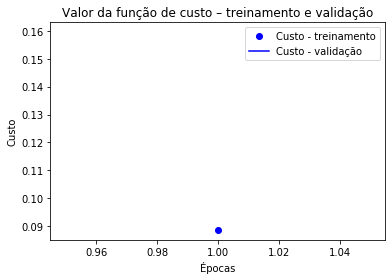

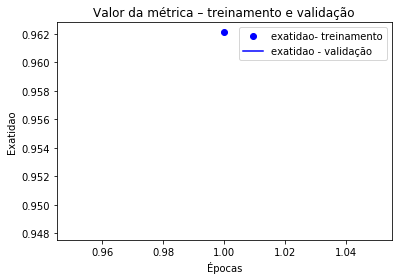

In [51]:
# Salva treinamento na variável history para visualização
resultado = results.history

# Salva custos, métricas e epocas em vetores 
custo = resultado['loss']
acc = resultado['accuracy']
val_custo = resultado['val_loss']
val_acc = resultado['val_accuracy']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'bo', label='exatidao- treinamento')
plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### 5.7 Avaliação e teste da RNA

Vamos avaliar o desemepnho da RNA usando o método `evaluate`com os dados de teste.

In [53]:
# Calcula função de custo e exatidão para os dados de teste 
loss, accuracy = rna.evaluate(balanced_ds_test, steps=10)

print(' ')
print("Função de custo:", loss)
print("Exatidão:", accuracy)

 1/10 [==>...........................] - ETA: 1:48 - loss: 0.1619 - accuracy: 0.9482

KeyboardInterrupt: 

#### Realizar previsões

Vamos verificar os resultados da RNA com detalhe usando o método predict e depois verificar o acerto para cada uma das classes.

In [55]:
# Gera lote de dados 
x, y_real = next(iter(balanced_ds_test))

Exatidão = 0.9501953125


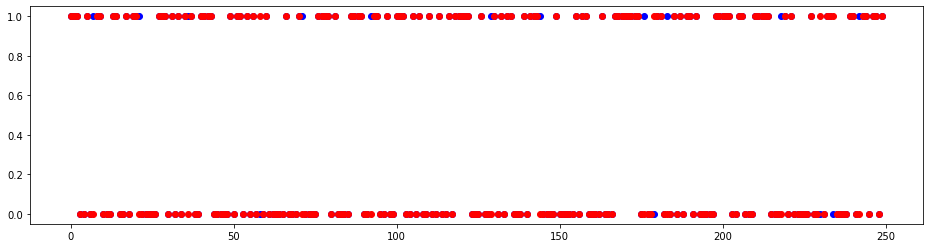

In [56]:
# Calcula previsão da RNA para um lote de imagens
y_prev = rna.predict(x)
classe_prev = np.round(y_prev)

# Redimensiona vetor de classes reais
classe_real = np.reshape(y_real, (1024, 1))

# Exatidão obtida
print('Exatidão =', 1.0 - np.mean(np.abs(classe_real-classe_prev)))

# Mostra primeiro exemplo do lote
plt.figure(figsize=(16,4))
plt.plot(y_real[:250], 'bo')
plt.plot(classe_prev[:250], 'ro')
plt.show()

In [ ]:
rna.save('rna.h5')